# Analyzing NYC High School Data

### Introduction
The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic datasets.

We will combine the following datasets into a single, clean pandas dataframe:
* SAT scores by school - SAT scores for each high school in New York City
* School attendance - Attendance information for each school in New York City
* Class size - Information on class size for each school
* AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* Graduation outcomes - The percentage of students who graduated and other outcome information
* Demographics - Demographic information for each school
* School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test.

### Read in the data

In [62]:
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [37]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN columns

In [38]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [39]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [40]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [41]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [42]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [43]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations

In [44]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


### Plotting survey correlations

In [45]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [46]:
survey_sat = survey_fields.copy()
survey_sat.append('sat_score')
combined[survey_sat].corr()['sat_score']

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
sat_score     1.000000
Name: sat_score, dtype: float64

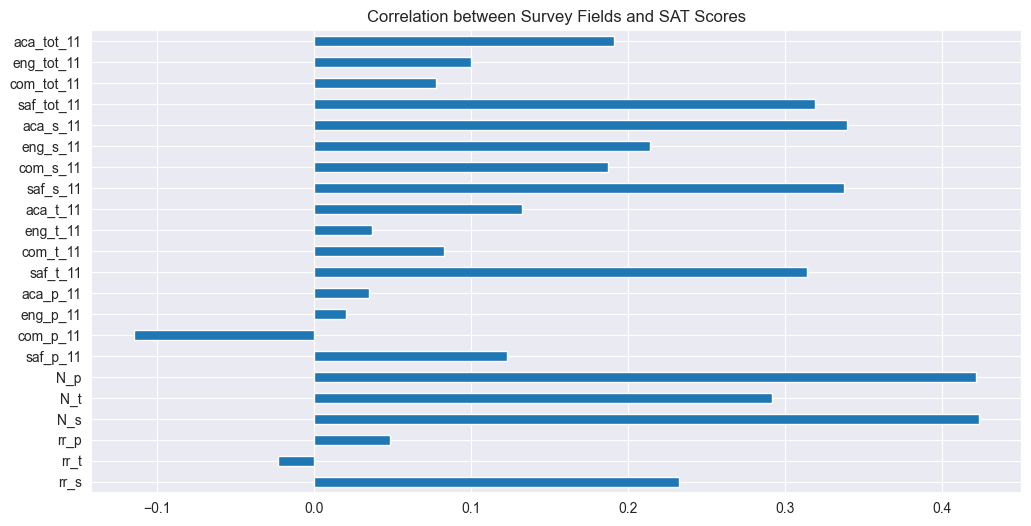

In [50]:
combined[survey_sat].corr()['sat_score'][:-1].plot.barh(figsize=(12,6))
plt.title('Correlation between Survey Fields and SAT Scores')
plt.show()

There is a clear general positive correlation between survey fields and sat scores. The highest positive correlations are with number of student respondents and number of parent respondents.

This means that the higher the responses from parent and students, the higher the sat score. This implies that for schools with parents and students willing to provide survey feedback on the school, there is a higher likelihood of higher sat scores. This makes sense. Where parent and students are actively involved with school, the students are more likely to successful at tests like the SATs.

There is one slight negative correlation with communication score based on parent responses.

### Exploring Safety and SAT Scores
saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score.

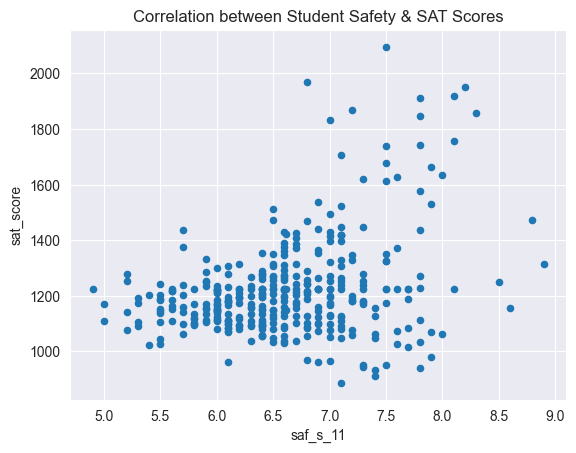

In [51]:
combined.plot(kind='scatter', x='saf_s_11', y='sat_score')
plt.title('Correlation between Student Safety & SAT Scores')
plt.show()

There is a positive correlation between student safety and sat scores. This correlation is evident for student safety scores in excess of 7.5.

Below, we'll compute the average safety score per borough. For this we'll be using the saf_tot_11 column which is the total safety and respect score.

In [58]:
print(*combined.columns, sep = "\n")

DBN
SCHOOL NAME
Num of SAT Test Takers
SAT Critical Reading Avg. Score
SAT Math Avg. Score
SAT Writing Avg. Score
sat_score
SchoolName
AP Test Takers 
Total Exams Taken
Number of Exams with scores 3 4 or 5
Demographic
School Name
Cohort
Total Cohort
Total Grads - n
Total Grads - % of cohort
Total Regents - n
Total Regents - % of cohort
Total Regents - % of grads
Advanced Regents - n
Advanced Regents - % of cohort
Advanced Regents - % of grads
Regents w/o Advanced - n
Regents w/o Advanced - % of cohort
Regents w/o Advanced - % of grads
Local - n
Local - % of cohort
Local - % of grads
Still Enrolled - n
Still Enrolled - % of cohort
Dropped Out - n
Dropped Out - % of cohort
CSD
NUMBER OF STUDENTS / SEATS FILLED
NUMBER OF SECTIONS
AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS
SCHOOLWIDE PUPIL-TEACHER RATIO
Name
schoolyear
fl_percent
frl_percent
total_enrollment
prek
k
grade1
grade2
grade3
grade4
grade5
grade6
grade7
grade8
grade9
grade10
grade11
grade12
ell_num
ell_percen

In [61]:
borough = [col for col in combined.columns if 'boro' in col]
borough

['boro']

In [66]:
safety_scores = ['saf_s_11', 'saf_t_11', 'saf_tot_11']
combined.groupby('boro').agg(np.mean)[safety_scores]

,saf_s_11,saf_t_11,saf_tot_11
boro,,,
Bronx,6.606577,7.026882,7.322581
Brooklyn,6.370755,6.985849,7.129245
Manhattan,6.831370,7.287778,7.473333
Queens,6.721875,7.365625,7.387500
Staten Island,6.530000,7.210000,7.200000


On the average, teacher safety scores are higher than student safety scores. The lowest safety scores are in Brooklyn, while the highest are in Manhattan & Queens.

### Exploring Race and SAT Scores
There are a few columns that indicate the percentage of each race at a given school: white_per, asian_per, black_per and hispanic_per.

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

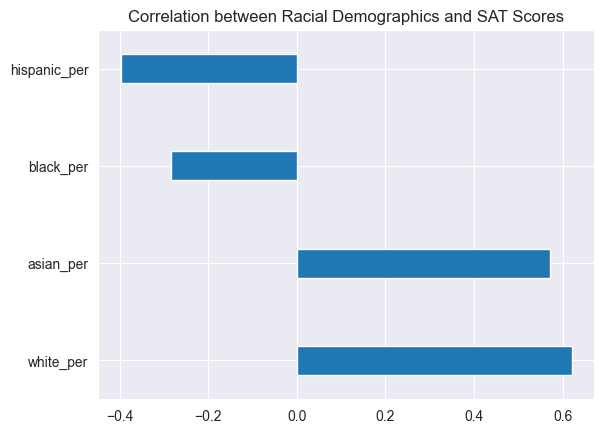

In [83]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']

combined[race_cols].corr()['sat_score'][:-1].plot.barh(width=0.3)
plt.title('Correlation between Racial Demographics and SAT Scores')
plt.show()

There is correlation between race and SAT scores. Black and hispanic students have a negative correlation and white and asian students have a positive correlation with SAT scores. This means the former group are less likely to succeed at SATs while the latter group are more likely.

Let's explore schools with high hispanic populations and low SAT scores

In [95]:
# Check correlation between percentage of hispanic population and SAT scores
combined[['hispanic_per', 'sat_score']].corr()['sat_score'][:-1]

hispanic_per   -0.396985
Name: sat_score, dtype: float64

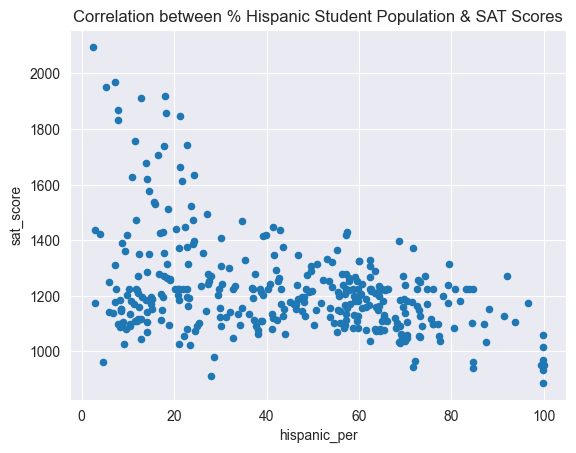

In [88]:
combined.plot(kind='scatter', x='hispanic_per', y='sat_score')
plt.title('Correlation between % Hispanic Student Population & SAT Scores')
plt.show()

We see there's a slight negative correlation between hispanic student population and SAT scores. This is especially clearer for schools with hispanic populations below 25%. Beyond this point, the negative correlation is only slightly visible.

In [97]:
# List of schools with high hispanic student populations and low sat scores
combined.loc[(combined['hispanic_per'] > 90) & (combined['sat_score'] < 1400)][['SCHOOL NAME', 'hispanic_per', 'boro', 'sat_score']]

,SCHOOL NAME,hispanic_per,boro,sat_score
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8,Manhattan,1058.0
80,CITY COLLEGE ACADEMY OF THE ARTS,92.0,Manhattan,1270.0
81,COMMUNITY HEALTH ACADEMY OF THE HEIGHTS,93.8,Manhattan,1105.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7,Manhattan,1174.0
84,HIGH SCHOOL FOR INTERNATIONAL BUSINESS AND FIN...,91.4,Manhattan,1127.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8,Manhattan,1014.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4,Bronx,951.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8,Bronx,934.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8,Bronx,970.0
253,MULTICULTURAL HIGH SCHOOL,99.8,Brooklyn,887.0


The majority of these schools are in the Manhattan borough. We can juxtapose this with our initial analysis that Manhattan boroughs have the highest safety scores and safety score is positively correlated with SAT scores. These schools may reflect outliers or exceptions in the dataset.

In [86]:
# Schools with a hispanic_per greater than 95%
combined.loc[combined['hispanic_per'] > 95][['SCHOOL NAME', 'hispanic_per']]

,SCHOOL NAME,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8
253,MULTICULTURAL HIGH SCHOOL,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0


In [98]:
# List of schools with low hispanic student populations and high sat scores
combined.loc[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)][
    ['SCHOOL NAME', 'hispanic_per', 'boro', 'sat_score']]

,SCHOOL NAME,hispanic_per,boro,sat_score
37,STUYVESANT HIGH SCHOOL,2.4,Manhattan,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,7.2,Bronx,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9,Brooklyn,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9,Queens,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,Staten Island,1953.0


Initial comparative analysis shows that the schools with higher sat scores and low hispanic populations are specialized schools targeted at gaining more successful SAT scores and other academic standards, compared with the high hispanic low SAT scores schools.

### Exploring Gender and SAT Scores

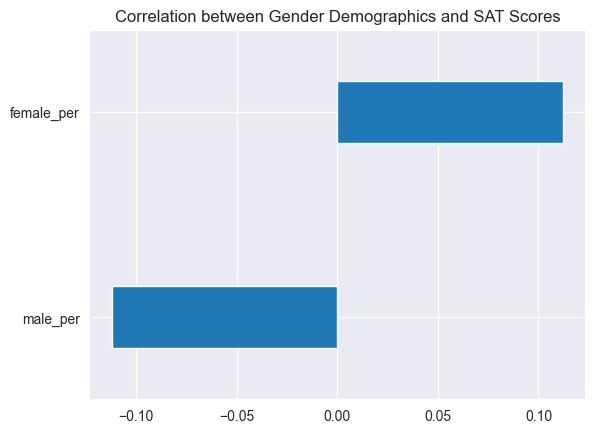

In [99]:
gender_cols = ['male_per', 'female_per', 'sat_score']

combined[gender_cols].corr()['sat_score'][:-1].plot.barh(width=0.3)
plt.title('Correlation between Gender Demographics and SAT Scores')
plt.show()

While correlation between gender and SAT scores is generally insignificant, males are negatively correlated with higher SAT scores and females are positively correlated with higher SAT scores.

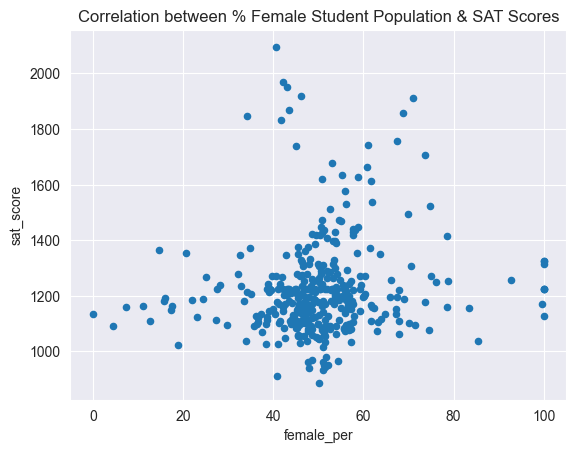

In [100]:
# Plot correlation between female population and SAT scores
combined.plot(kind='scatter', x='female_per', y='sat_score')
plt.title('Correlation between % Female Student Population & SAT Scores')
plt.show()

The scatter plot shows that there is no real correlation between female students and SAT scores.

In [101]:
# List of schools with high female student populations and high sat scores
combined.loc[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)][
    ['SCHOOL NAME', 'female_per', 'boro', 'sat_score']]

,SCHOOL NAME,female_per,boro,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,Manhattan,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,Manhattan,1758.0
60,BEACON HIGH SCHOOL,61.0,Manhattan,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,Manhattan,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,Queens,1910.0


### Exploring AP Scores vs. SAT Scores

In [102]:
# Calculate the percentage of students in each school that took an AP exam
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

combined[['ap_per', 'sat_score']].corr()['sat_score'][:-1]

ap_per    0.057171
Name: sat_score, dtype: float64

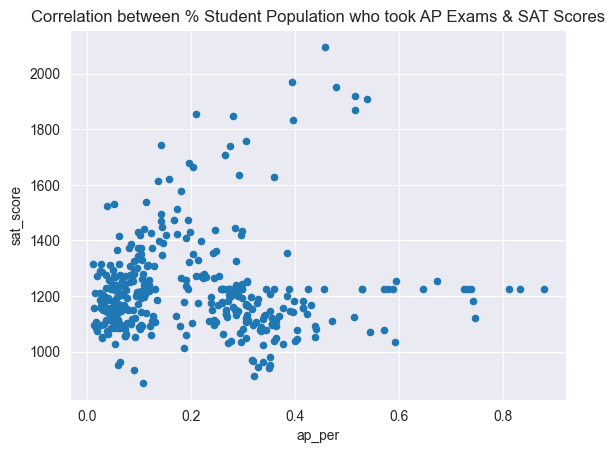

In [103]:
# Plot correlation between female population and SAT scores
combined.plot(kind='scatter', x='ap_per', y='sat_score')
plt.title('Correlation between % Student Population who took AP Exams & SAT Scores')
plt.show()

There is a slight positive correlation between percentage of AP Exam takers and higher SAT scores, however, the correlation is insignificant.

### Next Steps
* Determine whether there's a correlation between class size and SAT scores
* Figure out which neighborhoods have the best schools
* If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
* Investigate the differences between parent, teacher, and student responses to surveys.
* Assign scores to schools based on sat_score and other attributes.